In [1]:
import os
import tarfile
import urllib

from win32comext.mapi.mapiutil import prTable

Download_Root = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"

Housing_Path = os.path.join ("datasets", 'housing')
Housing_URL = Download_Root + 'datasets/housing/housing.tgz'

def fetch_housing_data (housing_url = Housing_URL,
                        housing_path = Housing_Path) :

    os.makedirs (Housing_Path, exist_ok = True)
    tgz_path = os.path.join (housing_path, 'housing.tgz')
    urllib.request.urlretrieve (housing_url, tgz_path)
    housing_tgz = tarfile.open (tgz_path)
    housing_tgz.extractall(path = housing_path)
    housing_tgz.close()

fetch_housing_data ()

import pandas as pd

def loading_housing_data (housing_path = Housing_Path) :
    csv_path = os.path.join(housing_path, 'housing.csv')
    return pd.read_csv (csv_path)

housing = loading_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [2]:
housing.info () #En "total bedrooms" hay unas celdas vacías, las hemos de tener en cuenta

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [3]:
housing ['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [4]:
housing.describe () #Descripción general de los datos

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


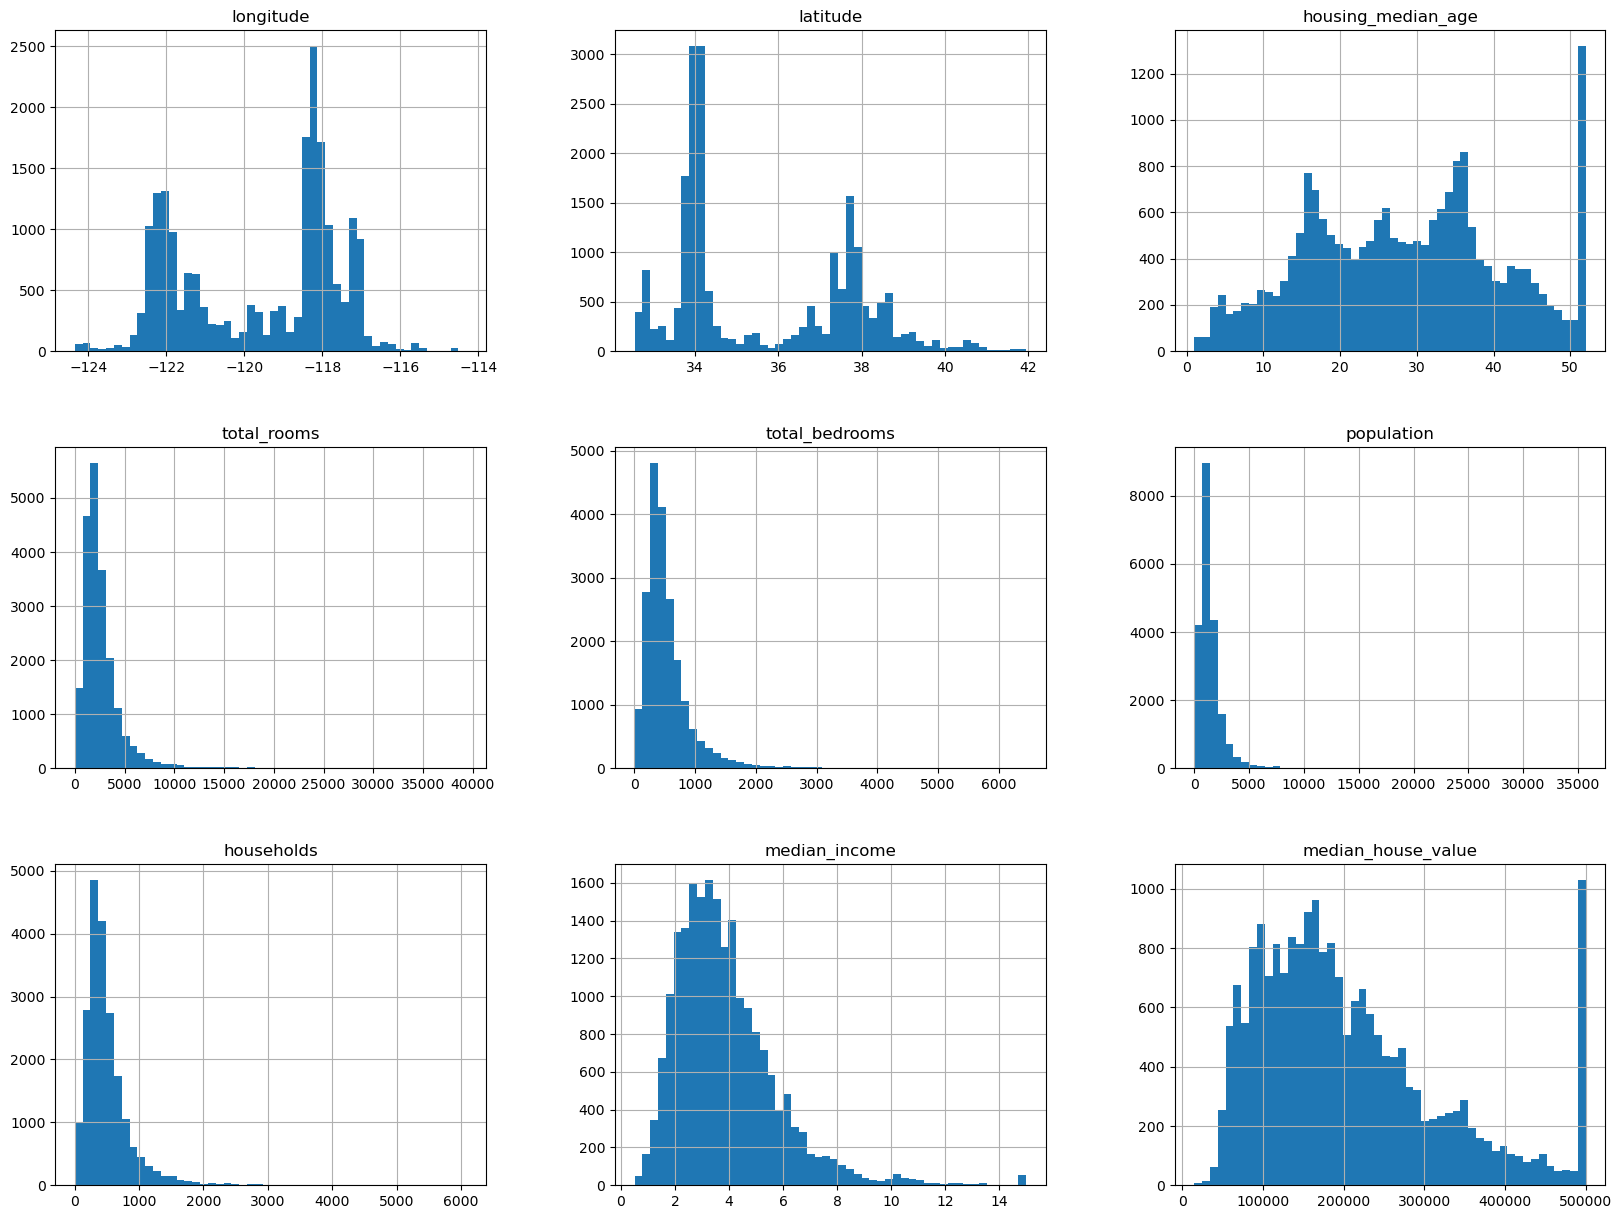

In [5]:
import matplotlib.pyplot as plt
housing.hist (bins = 50, figsize = (20, 15))
plt.show()

In [7]:
# Para separar un test set del training set. Por defecto vamos a usar un 20% de los datos.
# Hemos de asegurar que para cada sesión, y sin importar si actualizan los datos, el test set al menos NO debe variar.
# Para ello, el método que emplearemos, será guardar un test set que creamos de un sesión determinado, y llamaremos test set a aquel que creamos

from zlib import crc32
import numpy as np

def test_set_check (identifier, test_ratio):
    """
    Esto chequea si un Identicador pertenece o NO al test set. Devuelve un Booleano (T o F).
    El método crc32 devuelve un entero de 32 bit. Y el umbral que decide si va o NO al test set es el 2^32
    """
    return crc32 (np.int64 (identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id (data, test_ratio, id_column):
    """
    Esto llama a la función anterior que acabamos de crear. Si el id de la columna comple con la condición anterior (si devuelve true), está en test_set
    El método .loc [], pertenece a la librería pandas, que sirve para extraer datos de un data.frame según lo dentro de los corchetes:
    En este caso, devuelve 2 data.frames, que el primero será el train_set, mientras que el segundo será el test_set
    """
    ids = data [id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc [~in_test_set], data.loc [in_test_set]

#El problema ahora es que NO hay una columna de id en los datos de housing, para ello podemos crear una columna nueva de ids con el número de fila.

housing_with_id = housing.reset_index()   # adds an `index` column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")





In [8]:
train_set

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
3,3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
6,6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...,...
20635,20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


In [9]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split (housing, test_size = 0.2, random_state = 42)
"""
Hacer un muestreo aleatorizado es útil siempre y cuando el tamaño muestral es grande, en caso contrario, hemos de intentar mantener las proporciones de la población (muestreo estratificado).
En caso contrario, es muy fácil introducir sesgos a los resultados de análisis.
"""


<Axes: >

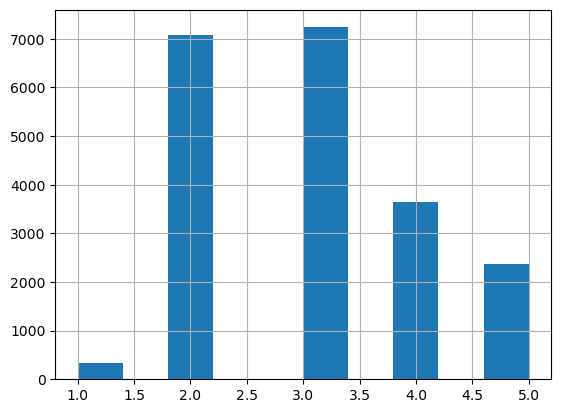

In [10]:
"""
Uno de los factores importantes es el ingreso medio, por tanto, es interesante si hacemos que los datos sean representativos según el ingreso medio
"""
housing ["income_cat"] = pd.cut (housing ["median_income"],
                                 bins = [0., 1.2, 3.0, 4.5, 6., np.inf],
                                 labels = [1, 2, 3, 4, 5]
                                 )
housing ["income_cat"].hist ()

In [26]:
"""
En la celda anterior hemos creado un objeto con las categorías por las que queremos separar los datos.
"""

from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit (n_splits = 1,
                                test_size = 0.2,
                                random_state = 42)

for train_index, test_index in split.split (housing, housing ["income_cat"]):
    strat_train_set = housing.loc [train_index]
    strat_test_set = housing.loc [test_index]

#El split dentro del loop es lo que de verdad separa los datos, el objeto anterior creado sirve para indicar los parámetros de los datos.

strat_train_set ["income_cat"].value_counts () / len (strat_train_set)

# (housing ["income_cat"].value_counts() / len (housing))

# El resultado que sale indica que es tal representativo de las proporciones a las de los datos iniciales.



income_cat
3    0.350594
2    0.342902
4    0.176296
5    0.114402
1    0.015807
Name: count, dtype: float64

In [28]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop ("income_cat", axis = 1, inplace = True)

"""
Esto quita la columna de "income_cat" del data.frame
"""



<Axes: xlabel='longitude', ylabel='latitude'>

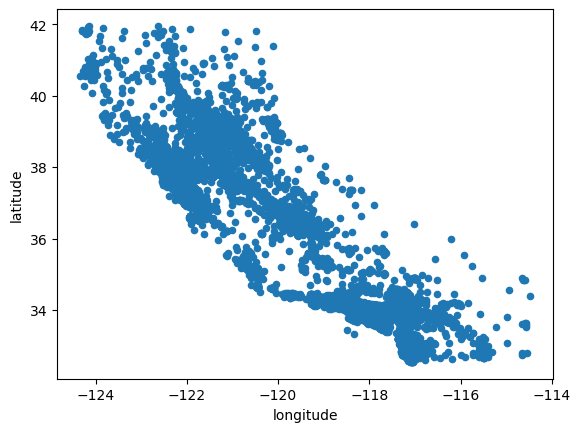

In [33]:
"""
De aquí a continuación se hará la visualización de datos. Usaremos una copia del training_set estratificado.
"""

housing = strat_train_set.copy ()
housing.plot (kind = "scatter", x = "longitude", y = "latitude")

#Los ejes son las columnas del data.frame que queremos plottear, si no existe da error


<Axes: xlabel='longitude', ylabel='latitude'>

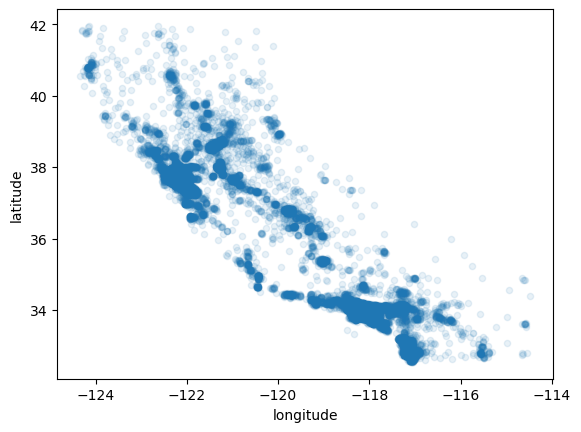

In [35]:
"""
Queremos ver más claro las zonas con más y menos densidad.
"""

housing.plot (kind = "scatter", x = "longitude", y = "latitude", alpha = 0.1)

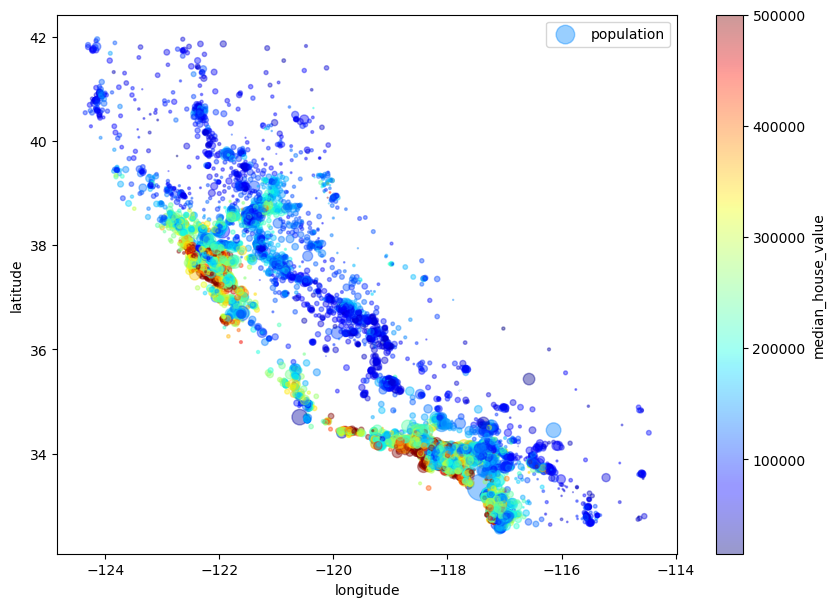

In [42]:
"""
Ahora queremos visualizar las zonas con precio diferentes de precio de casas.
"""

housing.plot (kind = "scatter",
              x = "longitude",
              y = "latitude",
              alpha = 0.4,
              s = housing ["population"] / 100,
              label = "population",
              figsize = (10, 7),
              c = "median_house_value", #Escala de los colores
              cmap = plt.get_cmap ("jet"), # Es otra escala de color
              colorbar = True
              )
plt.legend ()

"""
Con esto podemos ver que los precios depende mucho de la proximidad al mar.
"""

In [54]:
"""
Computar el coeficiente de correlación (linealidad). Indica la relación lineal. Si sale que es igual o similar a 0, indica que la relación es NO lineal.
"""

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
corr_matrix = housing [attributes].corr ()
corr_matrix ["median_house_value"].sort_values (ascending = False)

#

median_house_value    1.000000
median_income         0.690354
total_rooms           0.131034
housing_median_age    0.111590
Name: median_house_value, dtype: float64

array([[<Axes: xlabel='median_house_value', ylabel='median_house_value'>,
        <Axes: xlabel='median_income', ylabel='median_house_value'>,
        <Axes: xlabel='total_rooms', ylabel='median_house_value'>,
        <Axes: xlabel='housing_median_age', ylabel='median_house_value'>],
       [<Axes: xlabel='median_house_value', ylabel='median_income'>,
        <Axes: xlabel='median_income', ylabel='median_income'>,
        <Axes: xlabel='total_rooms', ylabel='median_income'>,
        <Axes: xlabel='housing_median_age', ylabel='median_income'>],
       [<Axes: xlabel='median_house_value', ylabel='total_rooms'>,
        <Axes: xlabel='median_income', ylabel='total_rooms'>,
        <Axes: xlabel='total_rooms', ylabel='total_rooms'>,
        <Axes: xlabel='housing_median_age', ylabel='total_rooms'>],
       [<Axes: xlabel='median_house_value', ylabel='housing_median_age'>,
        <Axes: xlabel='median_income', ylabel='housing_median_age'>,
        <Axes: xlabel='total_rooms', ylabel='housi

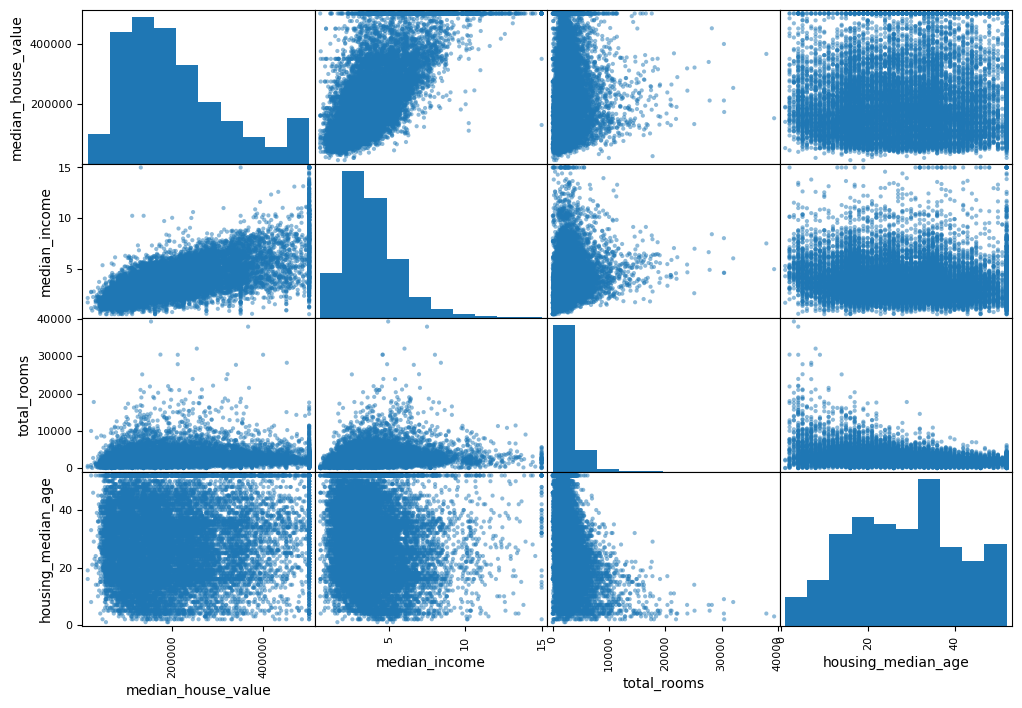

In [53]:
"""
Es otra forma de visualizar la linealidad (librería de Pandas)
"""

from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]

scatter_matrix (housing [attributes], figsize = (12, 8))

"""
Se ve la correlación más clara de medio de ingresos-precio medio de casas, en otros casos NO es tan clara la correlación.
"""

<Axes: xlabel='median_income', ylabel='median_house_value'>

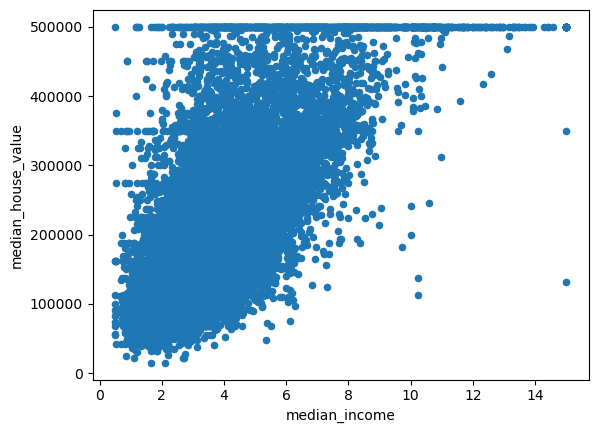

In [57]:
"""
Como indicado en la celda anterior, existe una correlación entre ingresos y precio de casa. Entonces vamos a plotearlos individualmente para ver cómo son.
"""

housing.plot (
             kind = "scatter",
             x = "median_income",
             y = "median_house_value"
             )

"""
Nota: Hay un cap obvio en 500000, es por el diseño (maybe, no me acuerdo). A lo mejor es necesario eliminar esos distritos para que el modelo no aprenda de estos peculiaridades.
"""

In [65]:
"""
Algunos datos no tiene mucho sentido si no se combina con otros, entonces es interesante crear nuevas columnas con nuevos atributos.
"""

housing ["rooms_per_household"] = housing ["total_rooms"] / housing ["households"]
housing ["bedrooms_per_room"] = housing ["total_bedrooms"] / housing ["total_rooms"]
housing ["population_per_household"] = housing ["population"] / housing ["households"]


array([[<Axes: xlabel='median_house_value', ylabel='median_house_value'>,
        <Axes: xlabel='median_income', ylabel='median_house_value'>,
        <Axes: xlabel='rooms_per_household', ylabel='median_house_value'>,
        <Axes: xlabel='bedrooms_per_room', ylabel='median_house_value'>,
        <Axes: xlabel='population_per_household', ylabel='median_house_value'>],
       [<Axes: xlabel='median_house_value', ylabel='median_income'>,
        <Axes: xlabel='median_income', ylabel='median_income'>,
        <Axes: xlabel='rooms_per_household', ylabel='median_income'>,
        <Axes: xlabel='bedrooms_per_room', ylabel='median_income'>,
        <Axes: xlabel='population_per_household', ylabel='median_income'>],
       [<Axes: xlabel='median_house_value', ylabel='rooms_per_household'>,
        <Axes: xlabel='median_income', ylabel='rooms_per_household'>,
        <Axes: xlabel='rooms_per_household', ylabel='rooms_per_household'>,
        <Axes: xlabel='bedrooms_per_room', ylabel='rooms_per

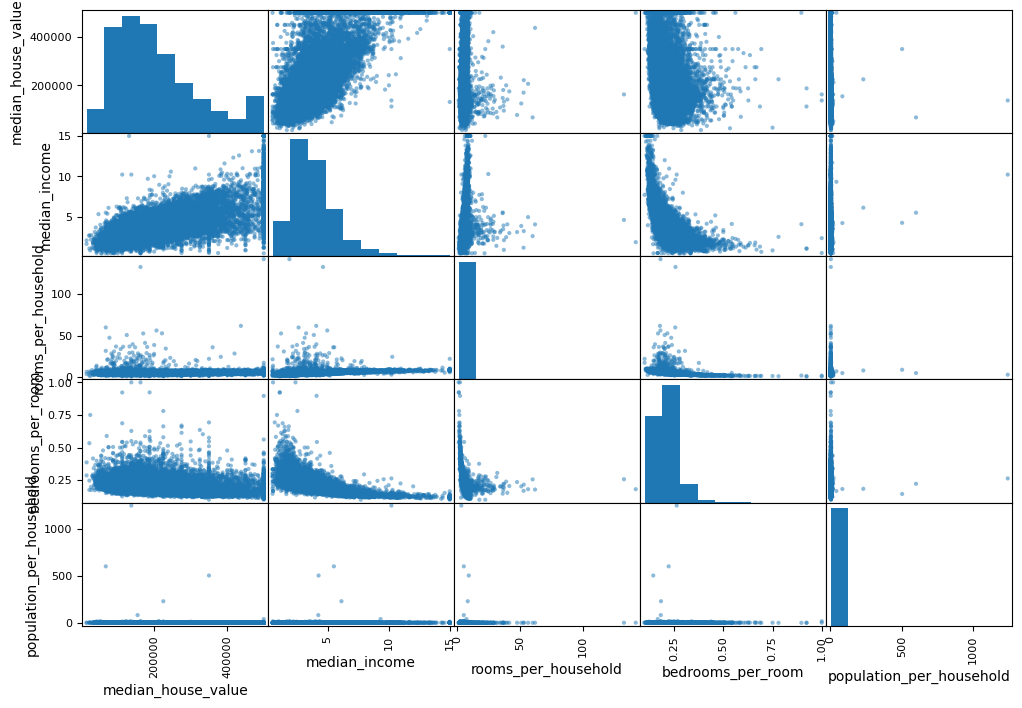

In [73]:
attributes = ["median_house_value", "median_income", "rooms_per_household", "bedrooms_per_room", "population_per_household"]


scatter_matrix (housing [attributes], figsize = (12, 8))


In [74]:
"""
De aquí a continuación, vamos a preparar los datos para machine-learning. (Data-cleaning). Requiere escritura de funciones para la reproducibilidad.
"""

housing = strat_train_set.drop ("median_house_value", axis = 1) #No queremos incluir la predicción
housing_labels = strat_train_set ["median_house_value"].copy () #Lo queremos en un objete separado



In [111]:
"""
La primera función que se usará tiene objetivo para tratar aquellos datos que faltan, ya que algunos algoritmos NO los tratan bien. Hay 3 posibilidades:
1. Eliminar la tupla entera
2. Eliminar el atributo entero.
3. Setearlo a un valor concreto => La media por ejemplo.
NOTA: Hemos de tener en cuenta que si sustituimos los valores N/A en el train set, lo debemos sustituir con el mismo valor en el test_set.
"""

media = 0
n = len (housing)
for bed_val in housing["total_bedrooms"]:
    if str (bed_val) != "nan":
        media = media + bed_val
    else:
        continue

media = media / n
print(media)



housing ["total_bedrooms"].fillna (media, inplace = True)


"""
Se ha elegido este método porque queremos guardar el valor de la media para poder usarla para sustituir los nan en el test_set. Se puede hacer con la librería de sklearn
"""











537.4220469552475


'\nSe ha elegido este método porque queremos guardar el valor de la media para poder usarla para sustituir los nan en el test_set. Se puede hacer con la librería de sklearn\n'

In [1]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer (strategy = "median")
housing_nostr = housing.drop ( "ocean_proximity", axis = 1) #NO trata los elementos str
imputer.fit (housing_nostr) # Esto rellena todos los huecos con la media computada de cada columna

medias = imputer.statistics_
housing_nostr.median ().values

X = imputer.transform (housing_nostr) #Es un ndarray de numpy.
# type (X)
#Hay que tranformarlo en un data.frame

housing_tr = pd.DataFrame (X,
                           columns = housing_nostr.columns,
                           index = housing_nostr.index8+
                           )




SyntaxError: invalid syntax (2939232447.py, line 17)

In [126]:
"""
Los atributos de strings son categoricos, no son pura azar, sino que cada string corresponde a una categoría. Lo podemos tranformar en números.
"""

housing_cat = housing [["ocean_proximity"]]


from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder ()
housing_cat_encoded = ordinal_encoder.fit_transform (housing_cat)
# housing_cat_encoded [ :10]
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [130]:
"""
Hay un pequeño problema, existen categorías muy parecidas. Para que los algoritmos los traten de forma diferente, una solución es usar programción one-hot. Esto consiste en crear un vector con la longtud como tantas categorías haya, si es de una categoría el valor es 1 en ese elemente, y 0 en restos. Es útil cuando no tenemos muchas categorías.
"""

from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder ()
housing_cat_1hot = cat_encoder.fit_transform (housing_cat)
housing_cat_1hot.toarray ()

array([[0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [171]:
"""
A veces tenemos que crear transformaciones personalizados.
"""

from sklearn.base import BaseEstimator, TransformerMixin #Permite que funcione como un transformer de sklearn

rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder (BaseEstimator, TransformerMixin):
    """
    Permite añadir al menos 2 columnas nuevas dependiendo del si es True o False el atributo "add_bedrooms_per_room", que es un hiperparámetro. Si solo usamos fit, no hace ninguan acción más que pegar los valores de la matriz inicial. Si usamos transform, estamos añadiendo 2 nuevas columnas calculadas a partir de información de columnas.
    """
    def __init__ (self, add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit (self, X, y = None):
        return (self)
    def transform (self, X, y = None):
        rooms_per_household = X [:, rooms_ix] / X [:, household_ix]
        population_per_household = X [:, population_ix] / X [:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X [:, bedrooms_ix] / X [:, rooms_ix]
            return np.c_[X,rooms_per_household,population_per_household,bedrooms_per_room]
        else:
            return np.c_[X,rooms_per_household,population_per_household]
attr_adder = CombinedAttributesAdder (add_bedrooms_per_room = False)
housing_extra_attribs = attr_adder.transform (housing.values)
housing_extra_attribs

array([[-117.47, 34.12, 6.0, ..., 'INLAND', 6.794212218649518,
        3.6591639871382635],
       [-117.73, 34.06, 34.0, ..., 'INLAND', 2.8907563025210083,
        2.6470588235294117],
       [-118.15, 34.11, 52.0, ..., '<1H OCEAN', 5.705882352941177,
        2.3006535947712417],
       ...,
       [-118.41, 34.15, 24.0, ..., '<1H OCEAN', 4.687951807228916,
        1.889156626506024],
       [-121.69, 38.87, 38.0, ..., 'INLAND', 4.336842105263158, 3.2],
       [-117.1, 32.68, 45.0, ..., 'NEAR OCEAN', 4.447368421052632,
        3.3834586466165413]], dtype=object)

In [173]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline ([
    ('imputer', SimpleImputer (strategy = "median")),
    ('attribs_adder', CombinedAttributesAdder ()),
    ('std_scaler', StandardScaler ()), #Normaliza con la media y la varianza, lo que hacer tener valores entre (la mayoría) entre [-3, 3].
])

housing_num_tr = num_pipeline.fit_transform (housing_nostr)
housing_num_tr


array([[ 1.056329  , -0.71727586, -1.79918346, ...,  0.51426024,
         0.04875244, -0.66322516],
       [ 0.92697632, -0.74524934,  0.4221562 , ..., -0.98227213,
        -0.03861068,  1.40911818],
       [ 0.71802199, -0.72193811,  1.85016026, ...,  0.09700924,
        -0.06851176, -0.35593892],
       ...,
       [ 0.58866931, -0.70328912, -0.37117939, ..., -0.2932516 ,
        -0.10403145,  0.11815362],
       [-1.0431645 ,  1.4972913 ,  0.73949044, ..., -0.42786233,
         0.00911822,  0.16283818],
       [ 1.24040782, -1.38863938,  1.29482535, ..., -0.38548803,
         0.02495404,  0.42510355]])

In [176]:
"""
Es una forma para tratar los variables numéricos y strings a la vez. Lo que sí necesitamos de antemano es un pipeline para tratar los variables numéricos. En este caso, es un objeto pipeline (), que se definió la celda anterior. Y un método para tratar los atributos tipo cadena, que se definió hace muchas celdas con el método OneHotEncoder. Ademas debes listar los elementos que son numéricos, que puede ser índices de las columnas o sus nombres.
"""
from sklearn.compose import ColumnTransformer

num_attribs = list (housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer ([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder (), cat_attribs),
])
housing_prepared = full_pipeline.fit_transform (housing)
housing_prepared

array([[ 1.056329  , -0.71727586, -1.79918346, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.92697632, -0.74524934,  0.4221562 , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.71802199, -0.72193811,  1.85016026, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.58866931, -0.70328912, -0.37117939, ...,  0.        ,
         0.        ,  0.        ],
       [-1.0431645 ,  1.4972913 ,  0.73949044, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.24040782, -1.38863938,  1.29482535, ...,  0.        ,
         0.        ,  1.        ]])

In [182]:
"""
Hasta ahora tenemos un nuevo set de datos que ha sido normalizado (StantardScaler), los atributos tipo string también ha sido tratado pasando a ser números, y los numéricos se han usado para crear 2 nuevas columnas con datos que nos interesa. Este sí es el set de datos que usaremos para entrenar modelos de machine-learning.
"""

#Para empezar vamos a usar un modelo de regresión lineal.

from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression ()
lin_reg.fit (housing_prepared, housing_labels)

some_data = housing.iloc [:5]
some_labels = housing_labels.iloc [:5]
some_data_prepared = full_pipeline.transform (some_data)
print ("predictions:", lin_reg.predict (some_data_prepared))


predictions: [114344.07675195 149400.02658489 244010.53081992 347268.23651895
  89702.70263532]


In [184]:
print ("Labels:", list (some_labels))

Labels: [141000.0, 117800.0, 364800.0, 352200.0, 114200.0]


In [185]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict (housing_prepared)
lin_mse = mean_squared_error (housing_labels, housing_predictions)
lin_rmse = np.sqrt (lin_mse)
lin_rmse

68537.86035483013

In [186]:
"""
Como puede ver, la predicción da bastante error, >40%. Esto indica que necesitamos un modelo más potente o simplemente los datos se nos quedan cortos. Pero aquí vamos a probar otro modelo que es más potente.
"""

from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor ()
tree_reg.fit (housing_prepared, housing_labels)
tree_predictions = tree_reg.predict (housing_prepared)
tree_mse = mean_squared_error (housing_labels, tree_predictions)
tree_rmse = np.sqrt (tree_mse)
tree_rmse

#Sale un error de 0, pero para comprobarlo necesitamos el test set


0.0

In [187]:
"""
Validación cruzada (cross-validation). Esto consiste en dividir el train set en dos sets, uno se usa para la validación, y el otro es un train set más pequeño. Se puede hacer con el método train_test_split.
"""

from sklearn.model_selection import cross_val_score

scores = cross_val_score (tree_reg,
                          housing_prepared,
                          housing_labels,
                          scoring = "neg_mean_squared_error",
                          cv = 10
                          )
tree_rmse_scores = np.sqrt (-scores) #Para indicar que mientras menor mejor, que la librería espera una función de utilidad, que es lo opuesto a MSE.
def display_scores (scores):
    print ("Scores:", scores)
    print ("Mean", scores.mean ())
    print( "Standard deviation", scores.std ())

display_scores (tree_rmse_scores)

"""
Estos resutados son incluso peores que usando un regresión lineal, porque hace una regresión que se ajusta perfectamente a los puntos usados para entrenar el modelo, sin embargo, al usar datos reales para validar el modelo, NO funciona bien. Esto no solo permite conocer el error, sino que podemos calcular también su desviación típica (error estándar). El problema del cross-validation es que perdemos datos para entrenar el modelo, por tanto, a veces NO se puede hacer.
"""


Scores: [72927.01063359 68883.53601599 69709.30905311 72206.11111375
 68213.08151521 70446.4217485  69087.46713494 73114.48536952
 68708.39327212 69124.82160124]
Mean 70242.06374579703
Standard deviation 1747.53118839164


In [188]:
"""
Por tanto, necesitaremos otro modelo pues que los modelos anteriores no funcionan bien. El que usaremos se llama RandomForestRegressor, que consiste en entrenar varios árboles de decisión y hacer media de sus predicciones. En un tipo de Ensemble Learning
"""

from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor ()
forest_reg.fit (housing_prepared, housing_labels)
forest_predictions = forest_reg.predict (housing_prepared)
forest_mse = mean_squared_error (housing_labels, forest_predictions)
forest_rmse = np.sqrt (forest_mse)
forest_rmse

18478.473207319257

In [189]:
scores = cross_val_score (
    forest_reg,
    housing_prepared,
    housing_labels,
    scoring = "neg_mean_squared_error",
    cv = 10
)

forest_reg_scores = np.sqrt (-scores)

display_scores (forest_reg_scores)

"""
El modelo tiene un rmse mucho más bajo en training set, lo que indica que overfit los datos. Para solucionarlo, o bien simplificamos los modelos o bien intentar obtener más datos.
"""

Scores: [50094.97954993 50292.785701   47285.76384902 46866.17066105
 48608.99442145 49384.56055667 50504.80354963 51329.78038738
 51625.8059479  51713.82034061]
Mean 49770.74649646455
Standard deviation 1633.2289175805702


In [ ]:
"""
Al tener los modelos entrenados podemos usar la librería de Python, joblib para guardar los parámetros del modelo
"""

#import joblib
#...



In [192]:
"""
Una vez que tenemos los modelos que a priori son muy comprometidos, tenemos que refinarlos. Una de las posibilidades sería introducir los valores manualmente. Otra es usar la opción GridSearchCV de sklearn.
"""

from sklearn.model_selection import GridSearchCV

param_grid = [
    {"n_estimators": [3, 10, 30], "max_features": [2, 4, 6,8]},
    {"bootstrap": [False], "n_estimators": [3, 10], "max_features": [2, 3, 4]}
]
forest_reg = RandomForestRegressor ()

grid_search = GridSearchCV (
    forest_reg,
    param_grid,
    cv = 5,
    scoring = "neg_mean_squared_error",
    return_train_score = True
)
grid_search.fit (housing_prepared, housing_labels)


,estimator,RandomForestRegressor()
,param_grid,"[{'max_features': [2, 4, ...], 'n_estimators': [3, 10, ...]}, {'bootstrap': [False], 'max_features': [2, 3, ...], 'n_estimators': [3, 10]}]"
,scoring,'neg_mean_squared_error'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,True
,n_estimators,30


In [193]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [194]:
cvres = grid_search.cv_results_
for mean_score, params in zip (cvres["mean_test_score"], cvres["params"]):
    print (np.sqrt (-mean_score), params)

"""
Con ello vemos que conseguimos mejorar la predicción, aunque en pequeña proporción. Pero vemos la idea básica de qué consiste tunear el modelo.
"""

64189.32962068913 {'max_features': 2, 'n_estimators': 3}
55388.86967204409 {'max_features': 2, 'n_estimators': 10}
52572.50911403401 {'max_features': 2, 'n_estimators': 30}
60006.16354149749 {'max_features': 4, 'n_estimators': 3}
53159.98965586185 {'max_features': 4, 'n_estimators': 10}
50183.874972070786 {'max_features': 4, 'n_estimators': 30}
59500.86547359556 {'max_features': 6, 'n_estimators': 3}
51787.32442689735 {'max_features': 6, 'n_estimators': 10}
49369.40933200385 {'max_features': 6, 'n_estimators': 30}
58302.33786908433 {'max_features': 8, 'n_estimators': 3}
51639.48795736562 {'max_features': 8, 'n_estimators': 10}
49784.37687390763 {'max_features': 8, 'n_estimators': 30}
61894.350375436334 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54190.57232435448 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59447.57040733681 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52073.68355904673 {'bootstrap': False, 'max_features': 3, 'n_estimators': 

In [196]:
"""
Otro método es búsqueda aleatorizado, que es mejor cuando tenemos muchos valores posibles de los hiperparámetros. Básicamente consiste en asignar valores randoms a los parámetros en cada iteración.
"""

from sklearn.model_selection import RandomizedSearchCV

forest_reg = RandomForestRegressor ()
random_search = RandomizedSearchCV (
    forest_reg,
    param_distributions=param_grid,
    n_iter = 1000,
    cv = 5,
    scoring = "neg_mean_squared_error",
    return_train_score = True
)
random_search.fit (housing_prepared, housing_labels)

C:\Users\leonz\anaconda3\envs\TFG_Yixi\lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 18 is smaller than n_iter=1000. Running 18 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


,estimator,RandomForestRegressor()
,param_distributions,"[{'max_features': [2, 4, ...], 'n_estimators': [3, 10, ...]}, {'bootstrap': [False], 'max_features': [2, 3, ...], 'n_estimators': [3, 10]}]"
,n_iter,1000
,scoring,'neg_mean_squared_error'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,nan


In [198]:
cvres = random_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

63538.97952986202 {'n_estimators': 3, 'max_features': 2}
55224.21112148676 {'n_estimators': 10, 'max_features': 2}
52414.544706701505 {'n_estimators': 30, 'max_features': 2}
60808.5708578492 {'n_estimators': 3, 'max_features': 4}
52540.81773287457 {'n_estimators': 10, 'max_features': 4}
49692.17071028262 {'n_estimators': 30, 'max_features': 4}
59550.109633016415 {'n_estimators': 3, 'max_features': 6}
52004.59682791984 {'n_estimators': 10, 'max_features': 6}
49400.27709352081 {'n_estimators': 30, 'max_features': 6}
57920.921928510266 {'n_estimators': 3, 'max_features': 8}
51415.234829220615 {'n_estimators': 10, 'max_features': 8}
49921.282996944276 {'n_estimators': 30, 'max_features': 8}
63227.543353393026 {'n_estimators': 3, 'max_features': 2, 'bootstrap': False}
54095.758845599965 {'n_estimators': 10, 'max_features': 2, 'bootstrap': False}
60116.50576344864 {'n_estimators': 3, 'max_features': 3, 'bootstrap': False}
52401.82361409959 {'n_estimators': 10, 'max_features': 3, 'bootstrap':

In [200]:
"""
Para tener una idea general de cómo de importantes son los metadatos, podemos listear los scores de importancias. Podemos jugar un poco con ello, dejando los atributos con menor importancia.
"""

feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances



array([7.97688739e-02, 7.32238426e-02, 4.11832650e-02, 1.71413618e-02,
       1.62643880e-02, 1.79675389e-02, 1.60403808e-02, 3.05007316e-01,
       6.71764006e-02, 1.07972712e-01, 8.59044335e-02, 7.63529873e-03,
       1.57621538e-01, 6.95444592e-05, 2.27410547e-03, 4.74899968e-03])

In [202]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list (cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs

sorted (zip (feature_importances, attributes), reverse=True)

"""
Una posibilidad sería que dejemos todos los otros categorías menos el 'INLAND', que tiene mucho más importancia que los otros categorías.
"""

[(0.3050073164018242, 'median_income'),
 (0.15762153779481447, 'INLAND'),
 (0.10797271246223904, 'pop_per_hhold'),
 (0.08590443346053138, 'bedrooms_per_room'),
 (0.0797688739153234, 'longitude'),
 (0.07322384256420993, 'latitude'),
 (0.06717640056461605, 'rooms_per_hhold'),
 (0.04118326500926459, 'housing_median_age'),
 (0.017967538856978434, 'population'),
 (0.017141361767901517, 'total_rooms'),
 (0.016264388022803805, 'total_bedrooms'),
 (0.01604038083864254, 'households'),
 (0.007635298728910647, '<1H OCEAN'),
 (0.0047489996820243964, 'NEAR OCEAN'),
 (0.0022741054707037796, 'NEAR BAY'),
 (6.954445921177619e-05, 'ISLAND')]

In [204]:
"""
Ya estamos en el último paso, evaluar el modelo en el test set
"""

final_model = grid_search.best_estimator_

X_test = strat_test_set.drop ("median_house_value", axis = 1)
y_test = strat_test_set ["median_house_value"].copy ()

X_test_prepared = full_pipeline.transform (X_test)

final_predictions = final_model.predict (X_test_prepared)

final_mse = mean_squared_error (y_test, final_predictions)
final_rmse = np.sqrt (final_mse)
final_rmse

49280.20187093557

In [206]:
"""
Para sacar un intervalo de confianza.
"""

from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt (stats.t.interval (confidence,
                           len (squared_errors) - 1,
                           loc = squared_errors.mean (),
                           scale = stats.sem (squared_errors),
                           )
         )

array([47016.64481123, 51444.25821775])